In [9]:
import sys
import numpy as np
import import_ipynb
from scipy.sparse.linalg import eigsh
from pathlib import Path

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))

# Verifique se os caminhos foram adicionados
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_pre_processing import read_mesh
    from fem_processing import boundary_conditions
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects
Modules imports were successful!


# Project 3: Rectangular Guide

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
### Geometry and mesh Domain

In [10]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'Ez_0'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

# Create mesh from file geometry
ps.create_mesh_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=1E-3, view_mesh=False)
mesh_data = read_mesh.get_data(FINITE_ELEMENT, BOUNDARY, MATERIAL, model='rectangular_guide')

Model rectangular_guide_domain_Triangle1 (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 3828 nodes in total
Info     : 7414 2-D elements in total


## Figure 1: Rectangular meshed domain

In [11]:
graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, model='rectangular_guide', Numbering=False)

Arquivo salvo em: c:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p31_rectangular_guide\pre_processing\pictures\rectangular_guide_meshed_domain_Triangle1.svg


<figure>
    <img src="pre_processing/pictures/rectangular_guide_meshed_domain_Triangle1.svg" alt="Fig.1" style="width:100%;" />
    <figcaption>Figure 1: Rectangular meshed domain $\Omega=[0,1]^2$.</figcaption>
</figure>

## `apply_physics()`

In [12]:
mesh_data = ps.apply_physics(FINITE_ELEMENT, mesh_data); mesh_data['cell'][1]

{'Tag': 245,
 'conn': [301, 2094, 3736],
 'material': {'tag': 201,
  'name': 'free_space',
  'relative_magnetic_permeability': 1,
  'relative_electric_permittivity': 1},
 'stiffness_a_value': 1,
 'mass_a_value': 1,
 'abc': {'type': None, 'conn_idx': None},
 'source': {'type': 'free_source', 'value': 0}}

In [13]:
mesh_data['nodes'][1]

{'xg': (0.0, 0.0), 'bc': {'type': 'Dirichlet', 'value': 0.0}}

## Imposition of Boundary Conditions

In [14]:
dirichlet_nodes = {key: value 
                   for key, value in mesh_data['nodes'].items() if value['bc']['type'] == 'Dirichlet'}

In [15]:
Nn = len(mesh_data['nodes']); Nd = len(dirichlet_nodes)
print(f"The entire domain has {Nn} nodes: {Nn - Nd} free nodes; {Nd} Dirichlet nodes.")

The entire domain has 3828 nodes: 3588 free nodes; 240 Dirichlet nodes.


## Processor Module

### Reduced Global matrix $A_{gr}$ with boundary conditions

In [16]:
Agr, fgr, Mgr, Pgr, Qgr = boundary_conditions.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Agr.shape)

Reduced global matrix shape: (3588, 3588)


## Eigenvalue Problem

In [17]:
# Resolver o problema de autovalor generalizado
# k Número de autovalores/autovetores desejados
eigenvalues, eigenvectors = eigsh(Agr, k=5, M=Mgr, which='SM')
print("Eigenvector shape:", eigenvectors.shape)

# Definir um limiar para eliminar erros de truncamento
threshold = 1e-8
positive_indices = np.where(eigenvalues > threshold)[0]

# Filtrar autovalores positivos e ordenar
sorted_positive_eigenvalues = eigenvalues[positive_indices]
sorted_positive_eigenvectors = eigenvectors[:, positive_indices]

# Ordenar os autovalores positivos e ajustar os autovetores na mesma ordem
sorted_indices = np.argsort(sorted_positive_eigenvalues)
sorted_positive_eigenvalues = sorted_positive_eigenvalues[sorted_indices]
sorted_positive_eigenvectors = sorted_positive_eigenvectors[:, sorted_indices]

# Resultados
print("Menores autovalores positivos:")
print(sorted_positive_eigenvalues)

print("\nAutovetores correspondentes (colunas correspondem aos autovalores):")
print(sorted_positive_eigenvectors)

Eigenvector shape: (3588, 5)
Menores autovalores positivos:
[ 7714.36052039 12346.56963786 20072.8170459  26259.12560925
 30902.14771037]

Autovetores correspondentes (colunas correspondem aos autovalores):
[[-0.48437909+1.75216558j  2.50669307+0.23227966j -0.21682531+1.65348238j
   1.21742573-3.42080758j -3.93232065-2.0607537j ]
 [-0.56525866+2.04473475j  1.98915451+0.18432258j  0.03148165-0.24007507j
   1.42132417-3.9937356j  -2.32959638-1.22083747j]
 [-0.57635616+2.08487824j -1.8804681 -0.17425129j  0.06703436-0.51119554j
  -1.44881199+4.07097282j -3.91037794-2.04925449j]
 ...
 [-0.75318921+2.72454413j -5.60688909-0.51955555j -1.09090429+8.31909807j
  -0.91611688+2.574169j   -0.08648313-0.04532199j]
 [-0.82958158+3.00088156j  6.17632763+0.57232188j -1.20187995+9.16538441j
  -0.4136542 +1.16231437j -2.7300173 -1.43068014j]
 [-0.34378386+1.24358434j -2.54922295-0.23622064j -0.49275136+3.75765951j
  -0.82902202+2.32944378j -2.01041157-1.05356698j]]


# Modos analíticos

In [18]:
tm_modes = ps.waveguide_modes(m_max=5, n_max=5, mode_type='TM')


Cinco menores autovalores analíticos dos modos TM:
TM_11: kc2 = 7710.628 rad2/m2
TM_21: kc2 = 12337.006 rad2/m2
TM_31: kc2 = 20047.634 rad2/m2
TM_12: kc2 = 26216.137 rad2/m2
TM_22: kc2 = 30842.514 rad2/m2


# `calculate_error()`

In [19]:
ps.calculate_error(tm_modes, sorted_positive_eigenvalues)

Modo TM_11: Erro percentual = 0.0484
Modo TM_21: Erro percentual = 0.0775
Modo TM_31: Erro percentual = 0.1256
Modo TM_12: Erro percentual = 0.1640
Modo TM_22: Erro percentual = 0.1933


# `Graphs()`

C:\Users\adilt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\tri\_tricontour.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z_check.max())
C:\Users\adilt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\tri\_tricontour.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z_check.min())
C:\Users\adilt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\tri\_tricontour.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  C = _tri.TriContourGenerator(tri.get_cpp_triangulation(), z)


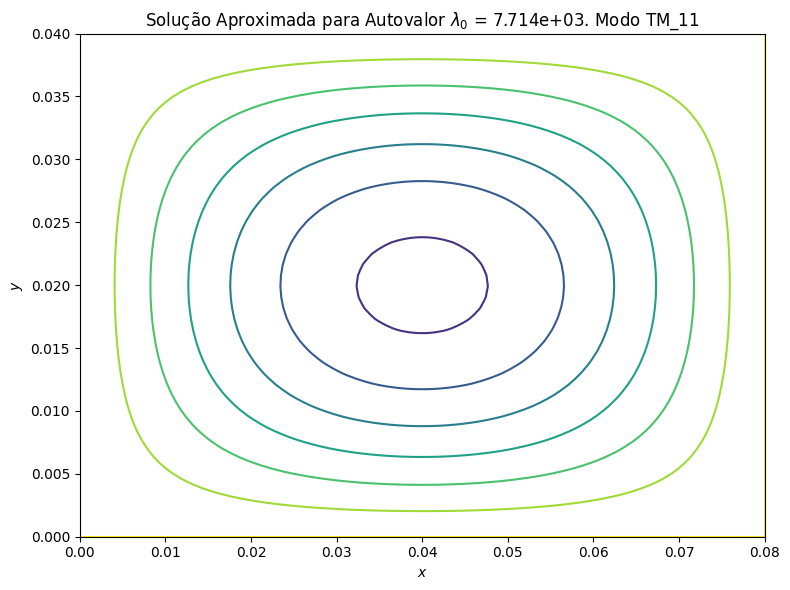

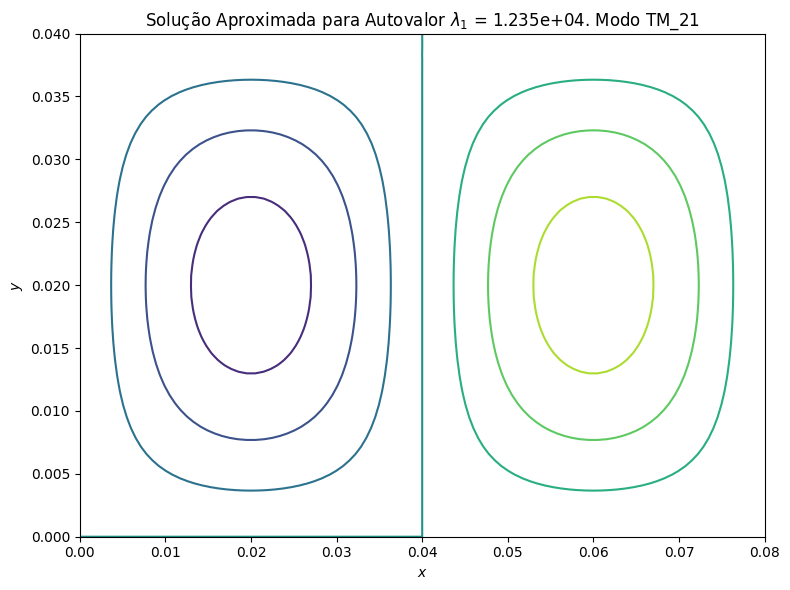

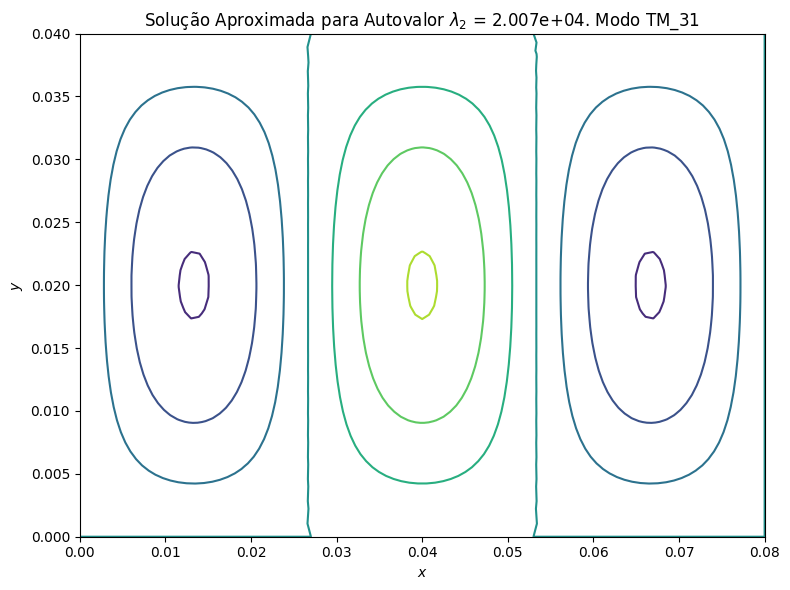

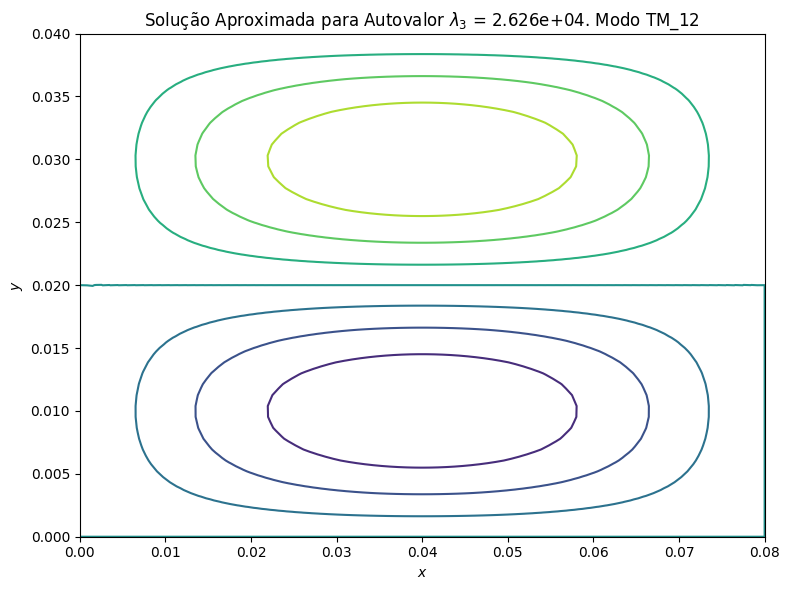

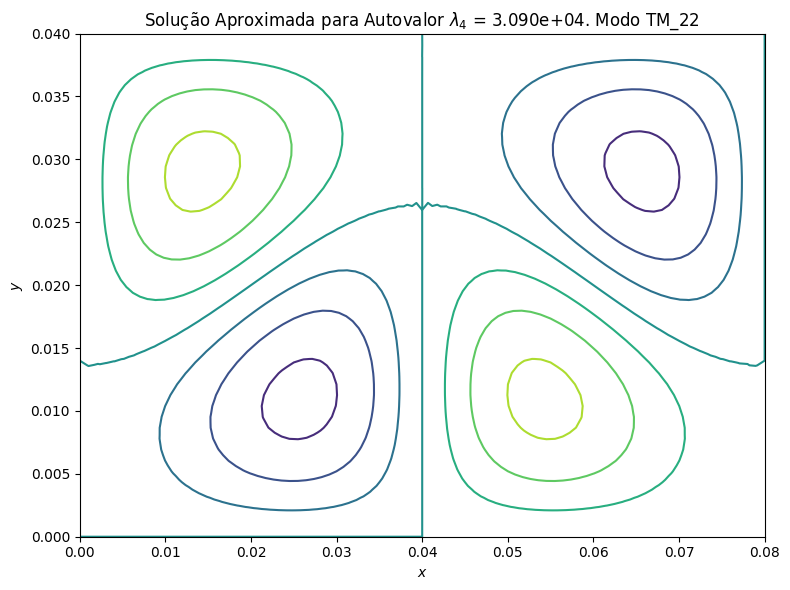

In [20]:
ps.get_modes_pattern(mesh_data, sorted_positive_eigenvalues, sorted_positive_eigenvectors, tm_modes)

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.